In [175]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)

import config

# Calibration


In [260]:

k=2/2.7
# k=1
calib_coeff = 443.2048098506353 /k# pe per volt
integral_1pe =  0.790754 *k
amplitude_1pe = 0.0053041233*k

# Scintillator Data

In [301]:
# filename = config.scope+"coincidence_preamp_v5/1_scintillator_light_output_test.joblib"
# filename = config.scope+"coincidence_preamp_v5/3_scintillator_light_output_test_newSiPM.joblib"
# filename = config.scope+"coincidence_preamp_v5/4_short_long_bar.joblib"
# filename = config.scope+"coincidence_preamp_v5/5_scintillator_41V_2.joblib"
# filename = config.scope+"coincidence_preamp_v5/6_scintillator_41V_two_fiber.joblib"
# filename = config.scope+"coincidence_preamp_v5/6_scintillator_41V_two_fiber_again.joblib"

filename = config.scope+"coincidence_preamp_v5/7_tripple_channel_41V_0.joblib"





data_save = joblib.load(filename)
time_series = data_save["metadata"]["time_series"]*1e9

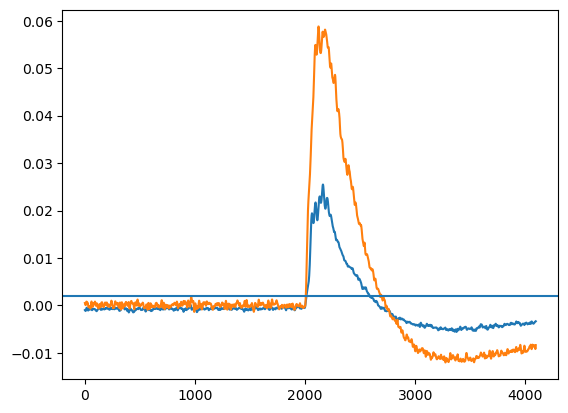

In [291]:
i=2
plot(data_save[1][i])
plot(data_save[2][i])

# plot(scipy.ndimage.gaussian_filter(data_save[2][i], 7))


trigger_threshold_edge = amplitude_1pe*.5
axhline(trigger_threshold_edge)


In [326]:
threshold_npe = 1.5
trigger_threshold_edge = [amplitude_1pe*threshold_npe, amplitude_1pe*threshold_npe]

trace_length = len(data_save[2][0])
pre_trig = trace_length//2-400




process_result = {}
for ch in [1,2]:
    process_result[f"trigger_time_edge_{ch}"]=[]
    process_result[f"trigger_time_cfd_{ch}"]=[]
    process_result[f"trigger_time_fit_{ch}"]=[]
    process_result[f"amplitude_{ch}"]=[]
    process_result[f"integral_{ch}"]=[]
    process_result[f"amplitude_fit_{ch}"]=[]
    process_result[f"trise_fit_{ch}"]=[]
    process_result[f"tfall_fit_{ch}"]=[]
    process_result[f"fit_chi2_{ch}"]=[]
    process_result[f"triggered_{ch}"]=[]
    

for i in tqdm(range(len(data_save[2]))):
# for i in tqdm(range(1000)):
    for ch in [1,2]:
        x=time_series
        y=data_save[ch][i]
        y-=np.mean(y[:1000])
        # y=scipy.ndimage.gaussian_filter(y, 5)

        dt = (time_series[1]-time_series[0])
        

        # Edge trigger:
        # trigger_time_edge = (np.argmax( y>trigger_threshold_edge[ch-1])-2048)*dt
        trigger_points, *_ = hp.Trigger.threshold_trigger(y[pre_trig:], trigger_threshold_edge[ch-1])
        triggered = len(trigger_points)>0
        trigger_time_edge = dt*(trigger_points[0]+ pre_trig - trace_length//2) if len(trigger_points)>0 else -999


        amplitude = np.max(y)
        integral = np.sum(y[:1500])
    
        
        process_result[f"trigger_time_edge_{ch}"].append(trigger_time_edge)
        process_result[f"amplitude_{ch}"].append(amplitude)
        process_result[f"integral_{ch}"].append(integral)
        process_result[f"triggered_{ch}"].append(triggered)

        
for key in process_result:
    process_result[key]=np.array(process_result[key])  


dt = process_result[f"trigger_time_edge_1"]-process_result[f"trigger_time_edge_2"]     
amp_min = np.min([process_result["amplitude_2"],process_result["amplitude_1"]],axis=0) 
amp_mean = np.mean([process_result["amplitude_2"],process_result["amplitude_1"]],axis=0) 

pe_ch1 =  process_result[f"amplitude_1"]*calib_coeff
pe_ch2 =  process_result[f"amplitude_2"]*calib_coeff
pe_ch1_int =  process_result[f"integral_1"]/integral_1pe
pe_ch2_int =  process_result[f"integral_2"]/integral_1pe
pe_min   = np.min([pe_ch1, pe_ch2],axis=0) 
pe_mean = np.mean([pe_ch1, pe_ch2],axis=0) 


process_result["dt"] = dt
process_result["amp_min"] = amp_min
process_result["amp_mean"] = amp_mean
process_result["pe_ch1_int"] = pe_ch1_int
process_result["pe_ch2_int"] = pe_ch2_int
process_result["pe_ch1"] = pe_ch1
process_result["pe_ch2"] = pe_ch2
process_result["pe_min"] = pe_min

joblib.dump(process_result, os.path.splitext(filename)[0]+"_processed.joblib")

100%|██████████| 1800/1800 [00:00<00:00, 27855.45it/s]


['/mnt/sda2//scope_data/coincidence_preamp_v5/7_tripple_channel_41V_0_processed.joblib']

(0.0, 50.0)

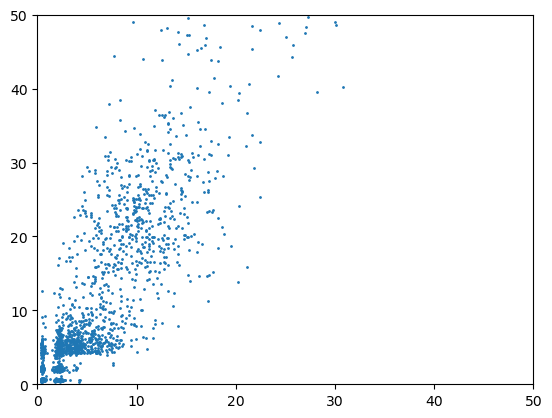

In [333]:
scatter(pe_ch1,pe_ch2, s=1);
xlim(0,50)
ylim(0,50)

219


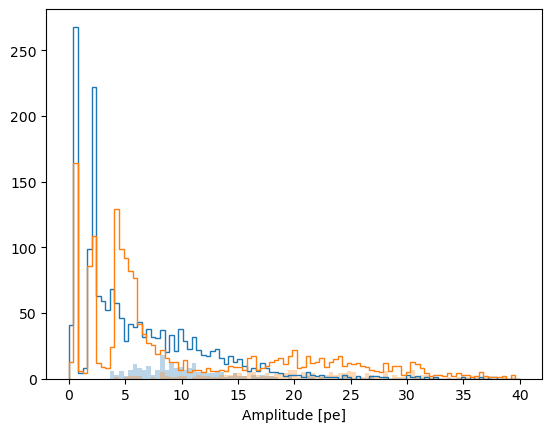

In [327]:
bins=np.linspace(0,40,100)
hist(process_result["pe_ch1"], bins=bins,histtype="step");
hist(process_result["pe_ch2"], bins=bins,histtype="step");

mask = (abs(dt-25)<5) & (process_result["trigger_time_edge_1"]>-999) &(process_result["trigger_time_edge_2"]>-999)
hist(process_result["pe_ch1"][mask], bins=bins,alpha=0.3, color="C0");
hist(process_result["pe_ch2"][mask], bins=bins,alpha=0.3, color="C1");
# ylim(0,300)
xlabel("Amplitude [pe]")
print(sum(mask))

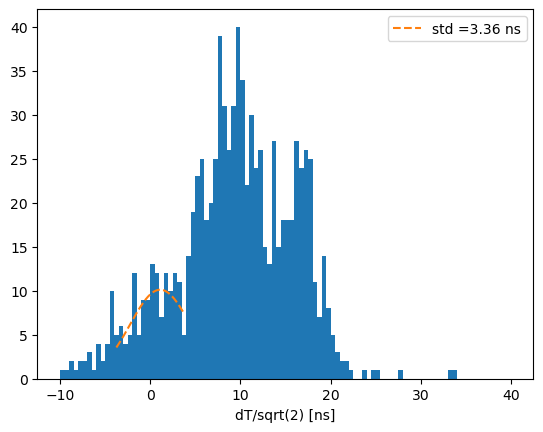

In [328]:
# scatter(pe_mean, dt,s=1)
# xlim(0,40)
# ylim(-10,10)
# xlabel("Charge [pe]")
# ylabel("dt [ns]")
# show()

mask = (process_result["pe_ch1"]>4) & (process_result["pe_ch2"]>4)

h=hist(dt[mask]/sqrt(2), range=(-10,40),bins=100);
popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-4,4), label="std ={popt[2]:.2f} ns", color="C1", linestyle="--");
legend()
xlabel("dT/sqrt(2) [ns]")
show()

[0.07675108 1.26557836 1.32363525]


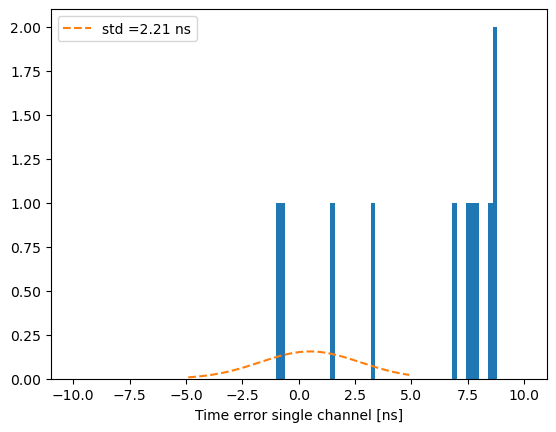

[0.09859293 0.23466704 0.26070838]


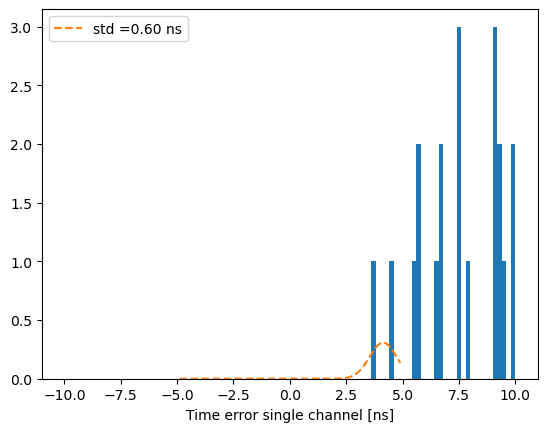

[inf inf inf]


/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:137: RuntimeWarning: invalid value encountered in double_scalars
  p0 = [np.max(ydata), mean, np.sqrt(np.sum(ydata*(xdata-mean)**2)/(np.sum(ydata)-1))] if p0 is None else p0
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


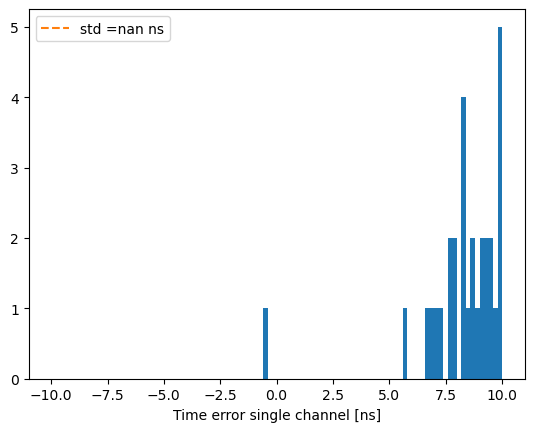

[inf inf inf]


/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:137: RuntimeWarning: invalid value encountered in double_scalars
  p0 = [np.max(ydata), mean, np.sqrt(np.sum(ydata*(xdata-mean)**2)/(np.sum(ydata)-1))] if p0 is None else p0
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


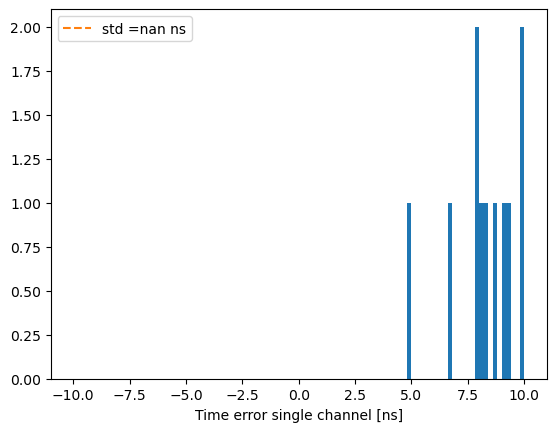

/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:136: RuntimeWarning: invalid value encountered in double_scalars
  mean = np.sum(xdata*ydata)/np.sum(ydata)
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[inf inf inf]


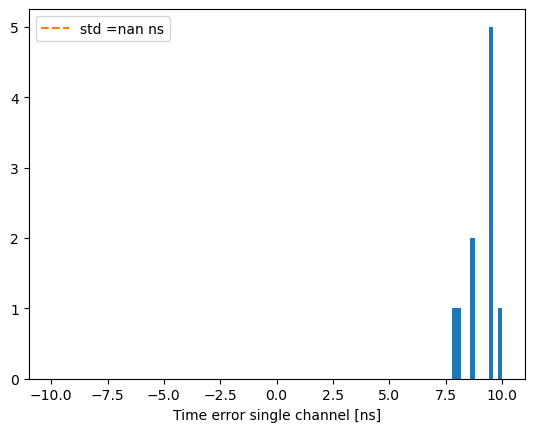

/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:137: RuntimeWarning: invalid value encountered in double_scalars
  p0 = [np.max(ydata), mean, np.sqrt(np.sum(ydata*(xdata-mean)**2)/(np.sum(ydata)-1))] if p0 is None else p0
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[inf inf inf]


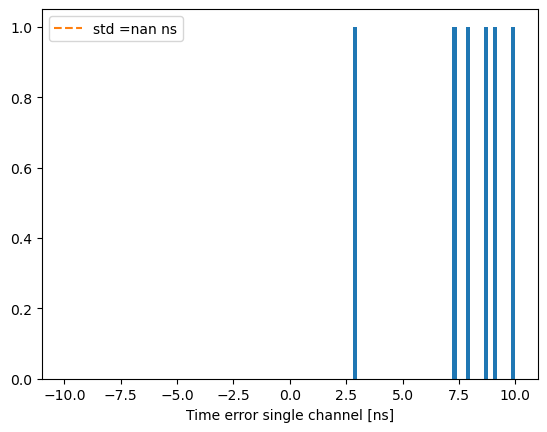

/home/mathusla/tofpet/Mu-Hardware/SystemCharacterization/../helper_basic.py:137: RuntimeWarning: invalid value encountered in double_scalars
  p0 = [np.max(ydata), mean, np.sqrt(np.sum(ydata*(xdata-mean)**2)/(np.sum(ydata)-1))] if p0 is None else p0
/usr/lib/python3/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[inf inf inf]


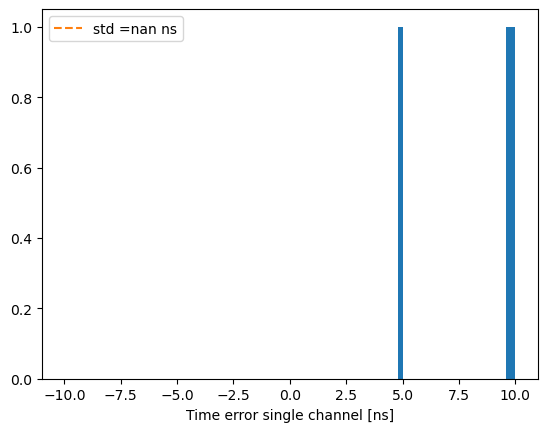

In [316]:
# mask = amp>0.02

# h=hist(dt[mask]/sqrt(2), range=(-10,10),bins=100);
# popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-3,3), label="std ={popt[2]:.2f} ns", color="C1", linestyle="--");
# legend()
# xlabel("Time error single channel [ns]")
# show()

# cut_edges = np.linspace(7,40,10)
cut_edges = [10,13,16,20,25,32,40,60]
amps = []
amps_min = []
sigmas = []


for icut  in range(len(cut_edges)-1):
    # mask = (pe_min>cut_edges[icut])&(pe_min<cut_edges[icut+1])
    mask = (pe_mean>cut_edges[icut])&(pe_mean<cut_edges[icut+1])

    h=hist(dt[mask]/sqrt(2), range=(-10,10),bins=100);

    popt, pcov, info, f = hp.fit_hist("gauss", h, fit_range=(-5,5), label="std ={popt[2]:.2f} ns", color="C1", linestyle="--");

    amps.append(np.mean(pe_ch2[mask]))
    amps_min.append(np.mean(pe_min[mask]))
    sigmas.append(popt[2])
    print(np.sqrt(np.diag(pcov)))

    legend()
    xlabel("Time error single channel [ns]")
    show()


In [296]:
sim =joblib.load("data/FastSim_scintillator_2.5_ns.joblib")
threshold_list =  sim["threshold_list"]
signal_npe_list = sim["signal_npe_list"]
t_fiber_list = sim["t_fiber_list"]
sim_results = sim["results"]
print(threshold_list, signal_npe_list, t_fiber_list)

[0, 1, 2, 3] [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] [1.5, 2, 3, 4, 5, 6, 7, 8]


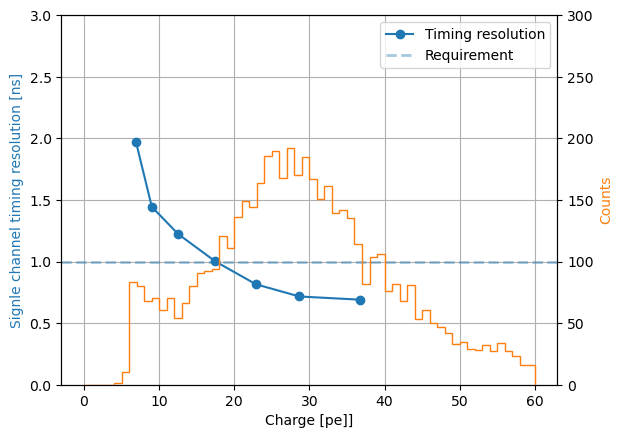

In [298]:


plot(amps_min, sigmas, marker="o", label="Timing resolution")
axhline(1, label="Requirement", color="C0", linewidth=2, alpha=0.4, linestyle="--")

# plot(signal_npe_list, sim_results[1,:, 1])


legend()
ylim(0,3)
xlabel("Charge [pe]]")
ylabel("Signle channel timing resolution [ns]")
grid()
gca().yaxis.label.set_color("C0")


gca().twinx()
hist(pe_ch2[abs(dt)<3],bins=60,range=(0,60),histtype="step",color="C1");
gca().yaxis.label.set_color("C1")
ylabel("Counts")
ylim(0,300)

savefig(os.path.splitext(filename)[0]+"_yield_and_timing_resolution.jpg")


In [286]:
30e3**2*50e-9

45.0